In [ ]:
!wget https://github.com/ravichaubey/Hack4Heritage-Hackathon/archive/master.zip
!unzip master.zip

In [ ]:
import os
os.chdir('/content/Hack4Heritage-Hackathon-master/Source Code')

## SETING UP

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

import os

import numpy as np
from models.skip import skip
from models import get_net

from util import *
import torch
import torch.optim
import torchvision
from skimage.measure import compare_psnr

from PIL import Image
import PIL.ImageDraw as ImageDraw
import PIL.ImageFont as ImageFont

torch.backends.cudnn.enabled = True
torch.backends.cudnn.benchmark =True
dtype = torch.cuda.FloatTensor

PLOT = True
imsize=-1
dim_div_by = 64
dtype = torch.cuda.FloatTensor
#dtype = torch.FloatTensor                     #### for work on cpu

## Reading Image

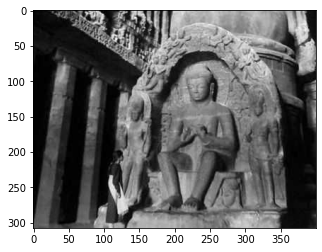

In [ ]:
## Please paste your image path on which you want to run
f = '/content/Hack4Heritage-Hackathon-master/Source Code/1.51343627.jpg'   

import cv2
img = cv2.imread(f, cv2.IMREAD_GRAYSCALE) 
h,w = img.shape
img = img.reshape((-1,h,w))


img_mask = get_bernoulli_mask(img, 0.50)

img_masked = img * img_mask

mask_var = torch.from_numpy(img_mask)[None, :].type(dtype)

plt.imshow(img.reshape(h,w), cmap = 'gray')

## Seting Up Network

In [ ]:
show_every=50
figsize=5
pad = 'reflection' # 'zero'
INPUT = 'noise'
input_depth = 32
OPTIMIZER = 'adam'
OPT_OVER =  'net'

LR = 0.001
num_iter = 11000
reg_noise_std = 0.03

NET_TYPE = 'skip'
net = get_net(input_depth, 'skip', pad, n_channels=1,
                  skip_n33d=128, 
                  skip_n33u=128, 
                  skip_n11=4, 
                  num_scales=5,
                  upsample_mode='bilinear').type(dtype)


mse = torch.nn.MSELoss().type(dtype)
img_var = torch.from_numpy(img)[None, :].type(dtype)

In [ ]:
net_input = get_noise(input_depth, INPUT, img.shape[1:]).type(dtype).detach()

## Training

Starting optimization with ADAM


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3121: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: UserWarning: DEPRECATED: skimage.measure.compare_psnr has been moved to skimage.metrics.peak_signal_noise_ratio. It will be removed from skimage.measure in version 0.18.
  del sys.path[0]
/usr/local/lib/python3.6/dist-packages/skimage/measure/simple_metrics.py:65: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im_true.
  return peak_signal_noise_ratio(im_true, im_test, data_range=data_range)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: UserWarning: DEPRECATED: skimage.measure.compare_psnr has been moved to skimage.metrics.pea

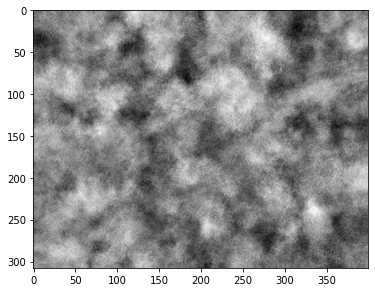

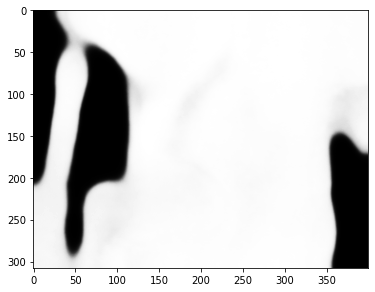

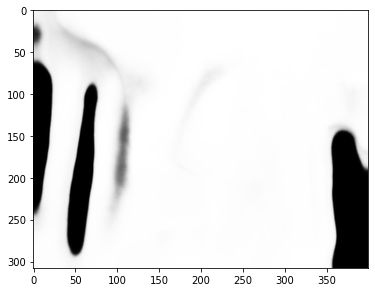

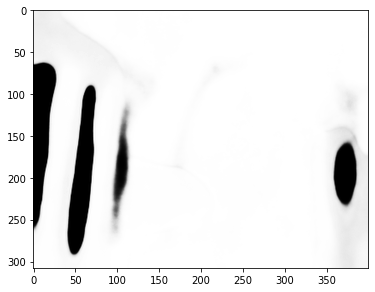

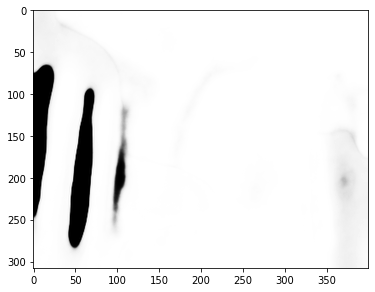

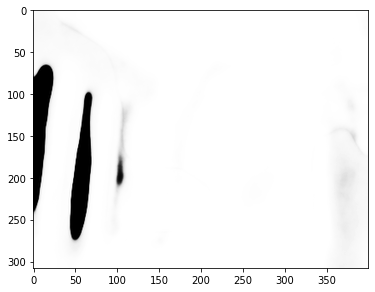

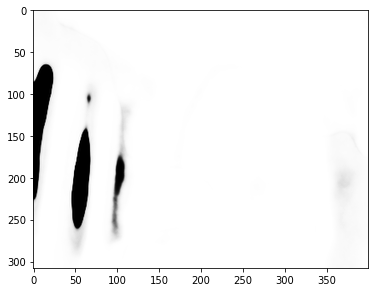

In [ ]:
def closure():

    global i, psrn_masked_last, last_net, net_input
    
    if reg_noise_std > 0:
        net_input = net_input_saved + (noise.normal_() * reg_noise_std)
    
    out = net(net_input)

    total_loss = mse(out * mask_var, img_var * mask_var)
    total_loss.backward()
    
    psrn_masked = compare_psnr(img_masked, out.detach().cpu().numpy()[0] * img_mask) 
    psrn = compare_psnr(img, out.detach().cpu().numpy()[0]) 

    print ('Iteration %05d    Loss %f PSNR_masked %f PSNR %f' % (i, total_loss.item(), psrn_masked, psrn),'\r', end='')
    
    
    if  PLOT and i % show_every == 0:
        out_np = out.detach().cpu().numpy()[0]
        
        # Backtracking
        if psrn_masked - psrn_masked_last < -5: 
            print('Falling back to previous checkpoint.')

            for new_param, net_param in zip(last_net, net.parameters()):
                net_param.data.copy_(new_param.cuda())

            return total_loss*0
        else:
            last_net = [x.cpu() for x in net.parameters()]
            psrn_masked_last = psrn_masked



        plot_image_grid([np.clip(out_np, 0, 1)], factor=figsize, nrow=1)

    i += 1

    return total_loss

# Init globals 
last_net = None
psrn_masked_last = 0
i = 0

net_input_saved = net_input.detach().clone()
noise = net_input.detach().clone()

# Run
p = get_params(OPT_OVER, net, net_input)
optimize(OPTIMIZER, p, closure, LR=LR, num_iter=num_iter)

## Result

In [ ]:
out_np = net(net_input).detach().cpu().numpy()[0]
q = plot_image_grid([np.clip(out_np, 0, 1), img], factor=13);